In [17]:
import tensorflow as tf
# from tensorflow import keras
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tf.config.run_functions_eagerly(True)

In [30]:
# Define the encoders
def create_encoder1(input_shape=(61, 100, 1), latent_dim=32):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder1")

def create_encoder2(input_shape=(61, 73, 61), latent_dim=32):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs, [z_mean, z_log_var, z], name="encoder2")

# Define the decoder
def create_decoder(latent_dim=64, output_shape=(480, 720, 3)):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(60 * 90 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((60, 90, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, outputs, name="decoder")

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE model
class MultiEncoderVAE(keras.Model):
    def __init__(self, encoder1, encoder2, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder1 = encoder1
        self.encoder2 = encoder2
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        input1, input2 = inputs
        z_mean1, z_log_var1, z1 = self.encoder1(input1)
        z_mean2, z_log_var2, z2 = self.encoder2(input2)
        z = tf.concat([z1, z2], axis=1)
        reconstruction = self.decoder(z)
        return reconstruction
    
    def train_step(self, data):
        (input1, input2), target = data
        with tf.GradientTape() as tape:
            z_mean1, z_log_var1, z1 = self.encoder1(input1)
            z_mean2, z_log_var2, z2 = self.encoder2(input2)
            z = tf.concat([z1, z2], axis=1)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    keras.losses.binary_crossentropy(target, reconstruction)
            )
            reconstruction_loss *= 480 * 720
            kl_loss = (-0.5) * (2 + z_log_var1 + z_log_var2 - tf.square(z_mean1) - tf.square(z_mean2) - tf.exp(z_log_var1) - tf.exp(z_log_var2))
            kl_loss = tf.reduce_mean(kl_loss)/2 # 2 is the number of encoders
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [19]:
# Data preprocessing
def preprocess_eeg(eeg_data):
    # Normalize EEG data
    return (eeg_data - np.mean(eeg_data)) / np.std(eeg_data)

def preprocess_fmri(fmri_data):
    # Normalize fMRI data
    return (fmri_data - np.mean(fmri_data)) / np.std(fmri_data)

def preprocess_images(image_data):
    # Normalize image data to [0, 1] range
    return image_data.astype('float32') / 255.0

# Custom data generator
class MultiInputDataGenerator(keras.utils.Sequence):
    def __init__(self, eeg_data, fmri_data, image_data, batch_size):
        self.eeg_data = eeg_data
        self.fmri_data = fmri_data
        self.image_data = image_data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.eeg_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_eeg = self.eeg_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_fmri = self.fmri_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.image_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return (batch_eeg, batch_fmri), batch_images




In [20]:
# Load and preprocess data
# Replace these with actual data
eeg_data = np.random.randn(100, 61, 100, 1)  # Example shape (samples, channels, timesteps, 1)
fmri_data = np.random.randn(100, 61, 73, 61)  # Example shape (samples, x_voxels, y_voxels, z_voxels)
image_data = np.random.randint(0, 256, (100, 480, 720, 3))  # Example shape (samples, height, width, channels)

In [21]:
eeg_data_p = preprocess_eeg(eeg_data)
fmri_data_p = preprocess_fmri(fmri_data)
image_data_p = preprocess_images(image_data)

# # Split the data into training and validation sets
# eeg_train, eeg_val, fmri_train, fmri_val, image_train, image_val = train_test_split(
#     eeg_data_p, fmri_data_p, image_data_p, test_size=0.2, random_state=42
# )

In [22]:
# Create data generators
batch_size = 32

train_generator = MultiInputDataGenerator(eeg_data_p, fmri_data_p, image_data_p, batch_size)
# val_generator = MultiInputDataGenerator(eeg_val, fmri_val, image_val, batch_size)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [31]:
# Create the model
latent_dim1 = 32
latent_dim2 = 32
output_shape = (480, 720, 3)
encoder1 = create_encoder1(input_shape=(61, 100, 1), latent_dim=latent_dim1)
encoder1.summary()
encoder2 = create_encoder2(input_shape=(61, 73, 61), latent_dim=latent_dim2)
encoder2.summary()
decoder = create_decoder(latent_dim=latent_dim1+latent_dim2, output_shape=output_shape)
decoder.summary()
vae = MultiEncoderVAE(encoder1, encoder2, decoder)

# Compile the model
vae.compile(optimizer=keras.optimizers.Adam())
vae.build(input_shape=[(batch_size, 61, 100, 1), (batch_size, 61, 73, 61)])
vae.summary()

Model: "encoder1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 61, 100,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 31, 50,    │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 25,    │     18,496 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 25600)     │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │    409,616 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │        544 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │        544 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_6          │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 429,520 (1.64 MB)

 Trainable params: 429,520 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 61, 73,    │          0 │ -                 │
│ (InputLayer)        │ 61)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 31, 37,    │     17,600 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 19,    │     18,496 │ conv2d_14[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 19456)     │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │    311,312 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │        544 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │        544 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_7          │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,496 (1.33 MB)

 Trainable params: 348,496 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 345600)         │    22,464,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 60, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 120, 180, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 240, 360, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 480, 720, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 480, 720, 3)    │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,524,451 (85.92 MB)

 Trainable params: 22,524,451 (85.92 MB)

 Non-trainable params: 0 (0.00 B)

Model: "multi_encoder_vae_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder1 (Functional)           │ [(None, 32), (None,    │       429,520 │
│                                 │ 32), (None, 32)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder2 (Functional)           │ [(None, 32), (None,    │       348,496 │
│                                 │ 32), (None, 32)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 480, 720, 3)    │    22,524,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,302,467 (88.89 MB)

 Trainable params: 23,302,467 (88.89 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:

# Train the model
epochs = 5
history = vae.fit(
    train_generator,
    epochs=epochs,
    # validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/5


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - kl_loss: 0.0336 - loss: 239551.7656 - reconstruction_loss: 239551.7344 - learning_rate: 0.0010
Epoch 2/5


c:\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss
  current = self.get_monitor_value(logs)
c:\Python311\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: kl_loss,loss,reconstruction_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - kl_loss: 0.0077 - loss: 239551.6562 - reconstruction_loss: 239551.6562 - learning_rate: 0.0010
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - kl_loss: 1.5635e-04 - loss: 239551.6875 - reconstruction_loss: 239551.6875 - learning_rate: 0.0010
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - kl_loss: 5.6059e-05 - loss: 239551.2500 - reconstruction_loss: 239551.2500 - learning_rate: 0.0010
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - kl_loss: 2.3024e-04 - loss: 239551.5156 - reconstruction_loss: 239551.5156 - learning_rate: 0.0010


In [33]:

# Save the model
vae.save('multi_encoder_vae_model.keras')

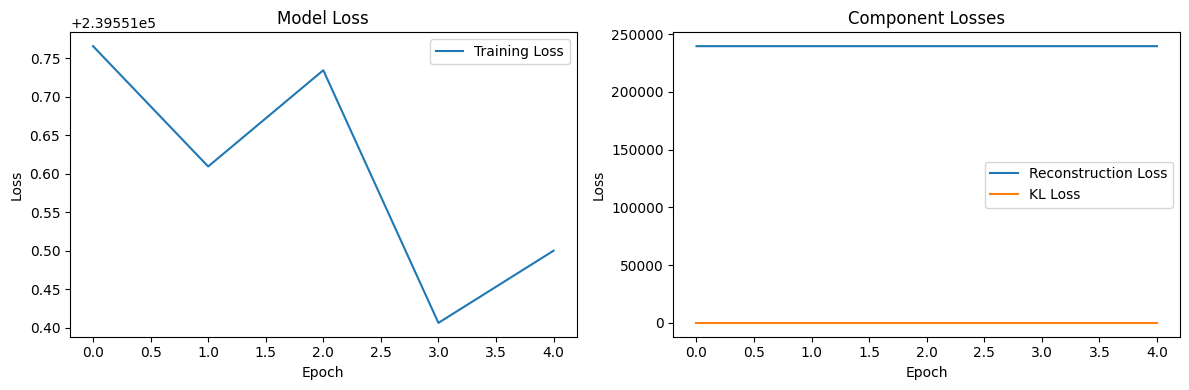

In [34]:
# Plot training history

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Component Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


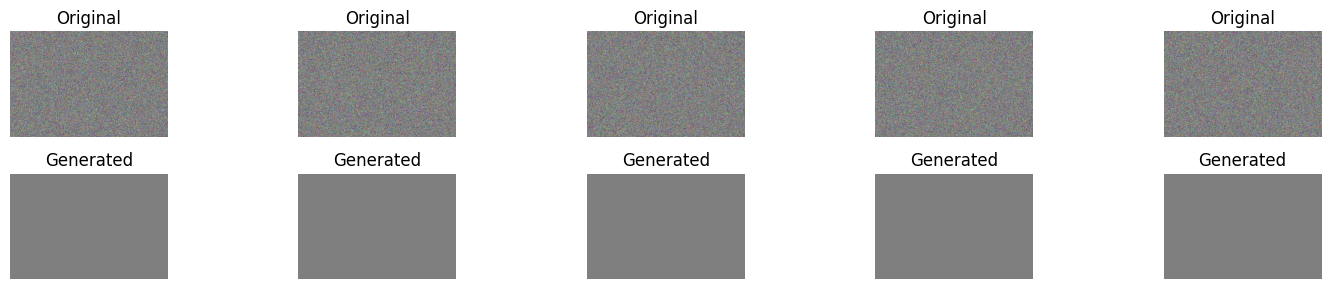

In [35]:

# Generate and display some sample images
num_samples = 5
sample_eeg = eeg_data_p[:num_samples]
sample_fmri = fmri_data_p[:num_samples]
sample_images = image_data_p[:num_samples]

generated_images = vae.predict((sample_eeg, sample_fmri))

plt.figure(figsize=(15, 3))
for i in range(num_samples):
    plt.subplot(2, num_samples, i+1)
    plt.imshow(sample_images[i])
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, num_samples, i+num_samples+1)
    plt.imshow(generated_images[i])
    plt.title('Generated')
    plt.axis('off')

plt.tight_layout()
plt.show()